<a href="https://colab.research.google.com/github/Shunian-Chen/AIPI510-Project/blob/main/Food_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI510 Project Food Price Prediction

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## 1. Data Cleaning

### 1.0 Import Libraries

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.gofplots import qqplot
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.metrics import r2_score,mean_squared_error

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### 1.1 Read Data
To be notice that at some moment, the gold price exceeds $1000 and there is a "," to indicate the thousand place, which will result in error when transfering string to float. Thus, add "thousands = ','" when reading data in. Moreover, some of the value in Crude Oil is ".", which will also result in error. Use pd.to_numeric to transfer the data and make the error term to be null value.

In [3]:
#Change working directory
PATH = "/content/drive/MyDrive/AIPI510-Project"
os.chdir(PATH)
os.getcwd()

'''
read data into a dictionary
key of the dictionary is the name of dataset
value of the dictionary is the value of that dataset, 
which contains both the date and price
'''
data_path = os.listdir(os.path.join(PATH, "Data"))
data_list = {}
columns = ["close", "value", "dcoilwtico", "usd", "m2"]              #columns that needed for analysis
for path in data_path:
  #read data
  data_path = os.path.join("Data", path)
  data = pd.read_csv(data_path, header = 0, thousands=',')

  #clean the column names
  data.columns = [h.lower().replace(" ", "") for h in data.columns]

  #extract columns needed
  col = ["date"] + data.columns[data.columns.isin(columns)].values.tolist()
  data = data[col]

  #rename the columns
  name = path.split(".")[0]
  data.columns = ["Date", name]

  #transfer datetime
  data["Date"] = pd.to_datetime(data["Date"])
  data.set_index("Date", inplace = True)

  #make sure data type is float
  data[name] = pd.to_numeric(data[name], errors = "coerce")

  #store the data in a dictory
  data_list[name] = data.copy()

M2 data is stock data, we want to use the change of m2 as a feature

In [4]:
m2 = data_list['M2'].shift(1)
data_list["M2"] =data_list["M2"]  - m2

### 1.2 Null Value Processing

#### 1.2.1 Count null values in each feature

In [5]:
def count_null(data):
  #count null values in each dataframe
  null_values = {"feature":[], "No. null":[]}
  for key, value in data.items():
    null_values["feature"].append(key)
    null_values["No. null"].append(sum(value[key].isna()))
  null_values = pd.DataFrame.from_dict(null_values)
  #visualize null values
  ax = plt.barh(height = 0.6, width = null_values["No. null"], y = null_values["feature"])
  return null_values

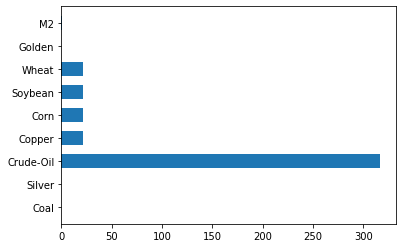

In [6]:
null_count = count_null(data_list)

#### 1.2.2 See how null values distributed in each feature
The results show that the missing values are mostly due to the days haven't arrive, except Crude Oil. That is, those days haven't really arrive when the data are collected. Therefore, these null values can be directly deleted.

In [7]:
nul_col = null_count[null_count['No. null'] != 0]["feature"]
for col in nul_col:
  print(data_list[col].index[data_list[col][col].isna()])

DatetimeIndex(['1986-02-17', '1986-03-28', '1986-05-26', '1986-07-04',
               '1986-09-01', '1986-10-13', '1986-11-27', '1986-12-25',
               '1986-12-26', '1987-01-01',
               ...
               '2020-11-26', '2020-11-27', '2020-12-25', '2021-01-01',
               '2021-01-18', '2021-02-15', '2021-04-02', '2021-05-31',
               '2021-07-05', '2021-09-06'],
              dtype='datetime64[ns]', name='Date', length=317, freq=None)
DatetimeIndex(['2021-11-09', '2021-11-10', '2021-11-11', '2021-11-12',
               '2021-11-13', '2021-11-14', '2021-11-15', '2021-11-16',
               '2021-11-17', '2021-11-18', '2021-11-19', '2021-11-20',
               '2021-11-21', '2021-11-22', '2021-11-23', '2021-11-24',
               '2021-11-25', '2021-11-26', '2021-11-27', '2021-11-28',
               '2021-11-29'],
              dtype='datetime64[ns]', name='Date', freq=None)
DatetimeIndex(['2021-11-09', '2021-11-10', '2021-11-11', '2021-11-12',
               '20

#### 1.2.3 Delete Null Values

In [8]:
data_no_null = {}
for key, value in data_list.items():
  data_no_null[key] = value[~value[key].isna()]

,feature,No. null
0,Coal,0
1,Silver,0
2,Crude-Oil,0
3,Copper,0
4,Corn,0
5,Soybean,0
6,Wheat,0
7,Golden,0
8,M2,0


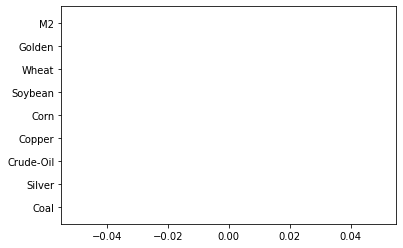

In [9]:
count_null(data_no_null)

### 1.3 Combine Data From Different Source

In [10]:
combo_data = pd.DataFrame()
for key, value in data_no_null.items():
  combo_data = combo_data.merge(value, left_index = True, right_index = True, how = "outer")

For m2, since we only have weekly data, we will use the number of the week to fill out the value in each day within that week

In [11]:
combo_data["M2"] = combo_data["M2"].fillna(method = "ffill")
combo_data

,Coal,Silver,Crude-Oil,Copper,Corn,Soybean,Wheat,Golden,M2
Date,,,,,,,,,
1959-07-01,NaN,NaN,NaN,NaN,1.177,NaN,1.964,NaN,NaN
1959-07-02,NaN,NaN,NaN,0.2930,1.176,NaN,1.971,NaN,NaN
1959-07-06,NaN,NaN,NaN,0.2910,1.171,NaN,1.970,NaN,NaN
1959-07-07,NaN,NaN,NaN,0.2820,1.171,NaN,1.971,NaN,NaN
1959-07-08,NaN,NaN,NaN,0.2846,1.170,NaN,1.964,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2021-11-05,148.25,24.535,NaN,4.3430,5.530,12.055,7.665,1801.9,-1.8
2021-11-06,NaN,24.535,NaN,NaN,NaN,NaN,NaN,NaN,-1.8
2021-11-07,NaN,24.175,NaN,NaN,NaN,NaN,NaN,NaN,-1.8


Then we only choose those days all feature are avaiable

In [12]:
combo_data = combo_data.dropna(axis = 0, how = 'any')
combo_data

,Coal,Silver,Crude-Oil,Copper,Corn,Soybean,Wheat,Golden,M2
Date,,,,,,,,,
2009-09-01,68.25,15.00750,68.11,2.8185,3.1925,9.5550,4.8725,955.0,4.7
2009-09-02,67.45,15.40250,68.03,2.8260,3.1925,9.5100,4.8575,964.8,4.7
2009-09-03,67.75,16.26250,67.90,2.8650,3.1575,9.4150,4.7875,983.0,4.7
2009-09-04,67.00,16.23750,67.95,2.8665,3.0625,9.2200,4.7175,989.0,4.7
2009-09-08,67.35,16.60000,71.08,2.9560,3.0750,9.3650,4.5900,1000.8,1.4
...,...,...,...,...,...,...,...,...,...
2021-10-26,234.00,24.13750,85.64,4.4860,5.4350,12.3990,7.5225,1785.6,-1.8
2021-10-27,232.85,24.04500,82.66,4.3895,5.5725,12.4345,7.5975,1795.3,-1.8
2021-10-28,233.00,24.09125,82.78,4.4385,5.6275,12.4110,7.7250,1803.5,-1.8


### 1.4 Outlier Dection

#### 1.4.1 Visualize Data
According to visualization, none of these data shown obvious trend or seasonal trend. It seems that the price of corn, copper, silver, soybean and golden are highly correlate by visual. And it can also be observed that there is an outlier in crude oil at the first of 2020, which is negative.

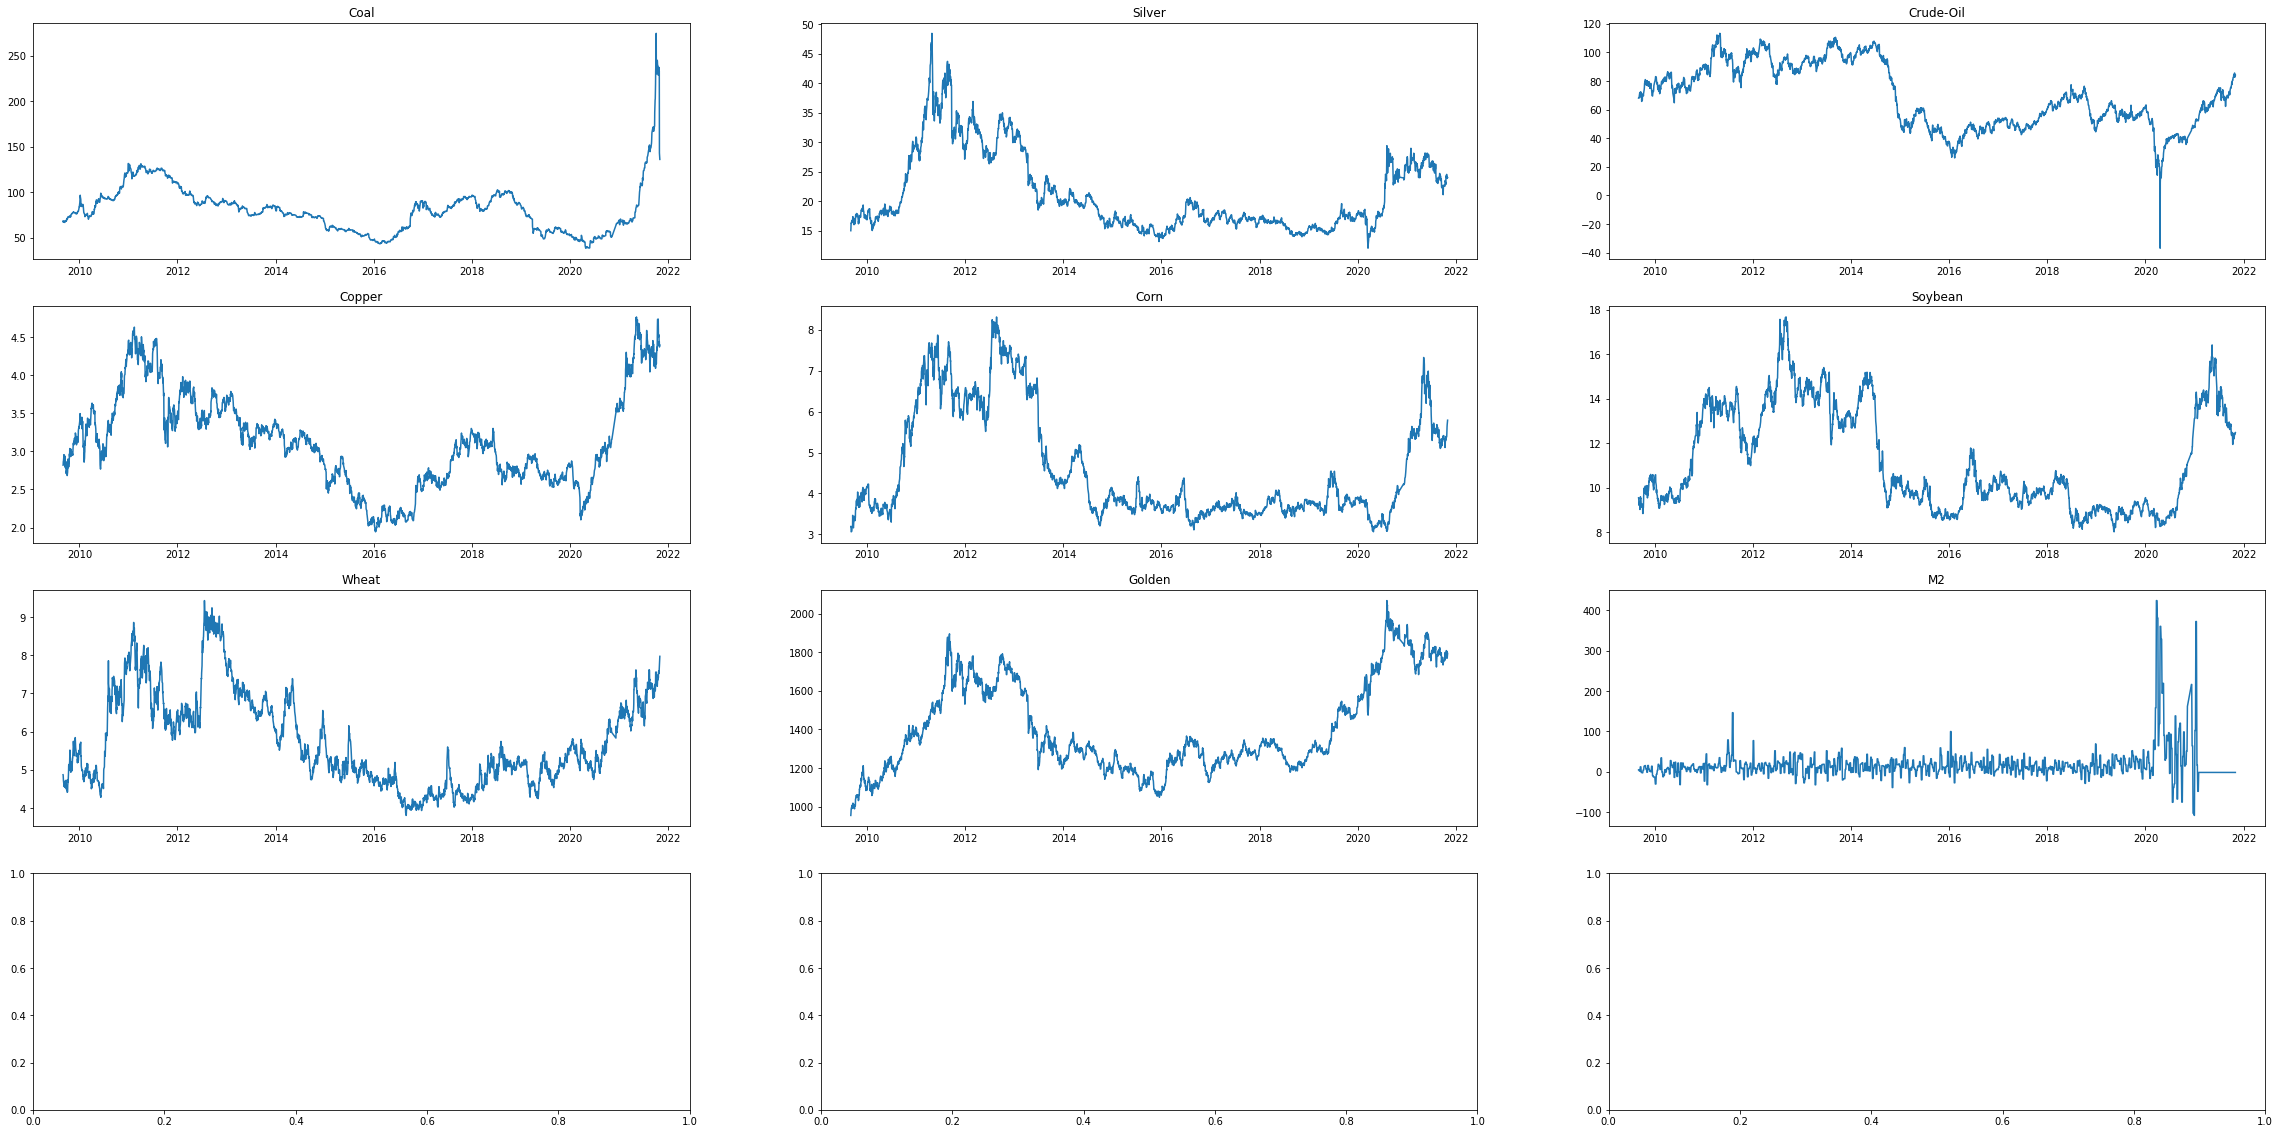

In [13]:
num = len(combo_data.columns)
fig, ax = plt.subplots(num//3 + 1, 3, figsize = (40, 20))

for i, sig in enumerate(combo_data.columns):
  axis = ax[i//3, i%3]
  axis.plot(combo_data[sig])
  axis.set_title(sig)
plt.show()

#### 1.4.2 Normality Assumption Check
Check normality assumption using QQ-Plot. It seems that none of these features follow normal distribution from QQ-Plot. Therefore, Outlier dection will be conducted using IQR method

In [14]:
def test_normality(data):
    cols = data.columns
    print(cols)
    for col in cols:
        m = np.mean(data.loc[:, col])
        s = np.std(data[col])
        qqplot(data[col], loc = m, scale = s, line = "45")
    plt.show()

Index(['Coal', 'Silver', 'Crude-Oil', 'Copper', 'Corn', 'Soybean', 'Wheat',
       'Golden', 'M2'],
      dtype='object')


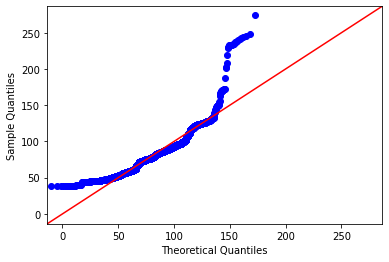

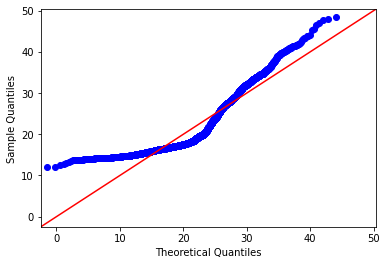

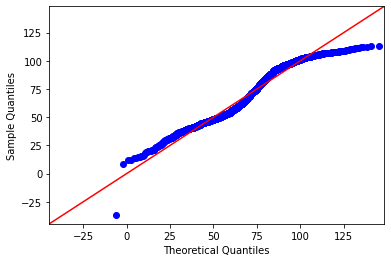

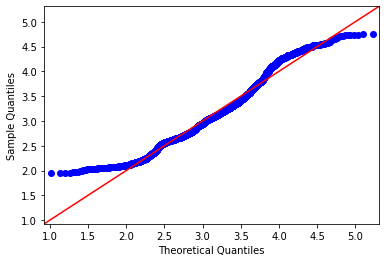

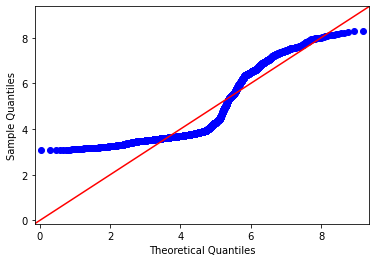

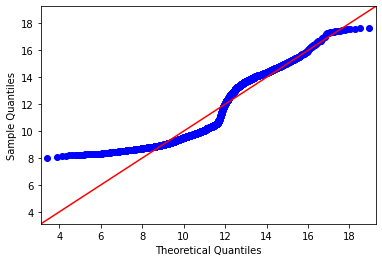

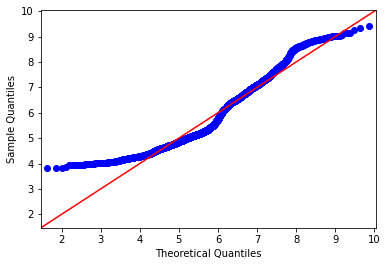

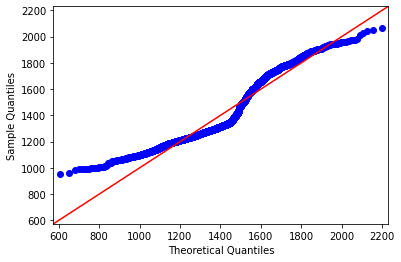

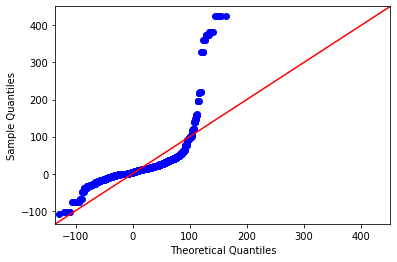

In [15]:
test_normality(combo_data)

#### 1.4.3 IQR
It is suprising that when we set the k = 10, even the negative oil price isn't been considered as outlier, which obviously should be. However, the change in M2 are considered as outliers for couple of days, which should not be the case. 

In [16]:
def detect_anomalies_iqr(col,k):
    quantile75 = col.quantile(q = 0.75)
    quantile25 = col.quantile(q = 0.25)
    IQR = quantile75 - quantile25
    upper = quantile75 + k * IQR
    lower = quantile25 - k * IQR

    idx = (col < lower) | (col > upper)
    return idx

In [17]:
k = 10
for col in combo_data.columns:
  print(combo_data[col].loc[detect_anomalies_iqr(combo_data[col], k)])

Series([], Name: Coal, dtype: float64)
Series([], Name: Silver, dtype: float64)
Series([], Name: Crude-Oil, dtype: float64)
Series([], Name: Copper, dtype: float64)
Series([], Name: Corn, dtype: float64)
Series([], Name: Soybean, dtype: float64)
Series([], Name: Wheat, dtype: float64)
Series([], Name: Golden, dtype: float64)
Date
2020-03-23    424.6
2020-03-24    424.6
2020-03-25    424.6
2020-03-26    424.6
2020-03-27    424.6
2020-03-30    381.3
2020-03-31    381.3
2020-04-01    381.3
2020-04-02    381.3
2020-04-03    381.3
2020-04-20    360.7
2020-04-21    360.7
2020-04-22    360.7
2020-04-23    360.7
2020-04-24    360.7
2020-04-27    329.1
2020-04-28    329.1
2020-04-29    329.1
2020-04-30    329.1
2020-05-01    329.1
2021-01-11    372.7
2021-01-12    372.7
2021-01-13    372.7
2021-01-14    372.7
2021-01-15    372.7
Name: M2, dtype: float64


Since we want to capture more information in recent fast-paced chaning era, we won't treat recent huge fluctuations as outliers. Therefore, when we set k = 2, several data points of silver and crude oil are considered as outliers

In [18]:
k = 2
idxs = np.full((combo_data.shape[0],), False)
for col in combo_data.columns.drop(["Coal", "M2"]):
  idxs = idxs | detect_anomalies_iqr(combo_data[col], k)
combo_data_no_outlier = combo_data[~idxs]
combo_data_no_outlier.head()

,Coal,Silver,Crude-Oil,Copper,Corn,Soybean,Wheat,Golden,M2
Date,,,,,,,,,
2009-09-01,68.25,15.0075,68.11,2.8185,3.1925,9.555,4.8725,955.0,4.7
2009-09-02,67.45,15.4025,68.03,2.8260,3.1925,9.510,4.8575,964.8,4.7
2009-09-03,67.75,16.2625,67.90,2.8650,3.1575,9.415,4.7875,983.0,4.7
2009-09-04,67.00,16.2375,67.95,2.8665,3.0625,9.220,4.7175,989.0,4.7
2009-09-08,67.35,16.6000,71.08,2.9560,3.0750,9.365,4.5900,1000.8,1.4


### 1.5 Food Price Index Calculation
The Food Price Index is calculated by weighted average using the price of corn, wheat and soybean. The formula is given by
$$ PI = \sum_{i=1}^{3} W_iP_i $$
Where
$$\sum_{i=1}^{3} W_i = 1,\ \forall \  W_i < 1$$


In [19]:
weights = {"Corn": 0.2, "Wheat": 0.5, "Soybean": 0.3}
PI = 0
for food, weight in weights.items():
  PI += combo_data_no_outlier[food] * weight
PI
data_pi = combo_data_no_outlier.drop(["Corn", "Wheat", "Soybean"], axis=1)
data_pi["PI"] = PI
data_pi

,Coal,Silver,Crude-Oil,Copper,Golden,M2,PI
Date,,,,,,,
2009-09-01,68.25,15.00750,68.11,2.8185,955.0,4.7,5.94125
2009-09-02,67.45,15.40250,68.03,2.8260,964.8,4.7,5.92025
2009-09-03,67.75,16.26250,67.90,2.8650,983.0,4.7,5.84975
2009-09-04,67.00,16.23750,67.95,2.8665,989.0,4.7,5.73725
2009-09-08,67.35,16.60000,71.08,2.9560,1000.8,1.4,5.71950
...,...,...,...,...,...,...,...
2021-10-26,234.00,24.13750,85.64,4.4860,1785.6,-1.8,8.56795
2021-10-27,232.85,24.04500,82.66,4.3895,1795.3,-1.8,8.64360
2021-10-28,233.00,24.09125,82.78,4.4385,1803.5,-1.8,8.71130


### 1.6 Data Normalization
Z-Score normalization is applied in data normalization

In [20]:
data_normalized = pd.DataFrame()
for col in data_pi.columns:
  m = np.mean(data_pi[col])
  s = np.std(data_pi[col])
  data_normalized[col] = (data_pi[col] - m) / s
data_normalized

,Coal,Silver,Crude-Oil,Copper,Golden,M2,PI
Date,,,,,,,
2009-09-01,-0.486616,-0.941665,-0.058673,-0.481303,-1.908934,-0.293171,-0.813386
2009-09-02,-0.516506,-0.881440,-0.062298,-0.469133,-1.867065,-0.293171,-0.827549
2009-09-03,-0.505298,-0.750316,-0.068189,-0.405854,-1.789308,-0.293171,-0.875098
2009-09-04,-0.533320,-0.754128,-0.065923,-0.403420,-1.763674,-0.293171,-0.950973
2009-09-08,-0.520243,-0.698858,0.075911,-0.258202,-1.713260,-0.370480,-0.962944
...,...,...,...,...,...,...,...
2021-10-26,5.706257,0.450380,0.735688,2.224295,1.639689,-0.445445,0.958189
2021-10-27,5.663289,0.436276,0.600651,2.067719,1.681131,-0.445445,1.009211
2021-10-28,5.668894,0.443328,0.606089,2.147224,1.716164,-0.445445,1.054871


<Figure size 720x720 with 0 Axes>

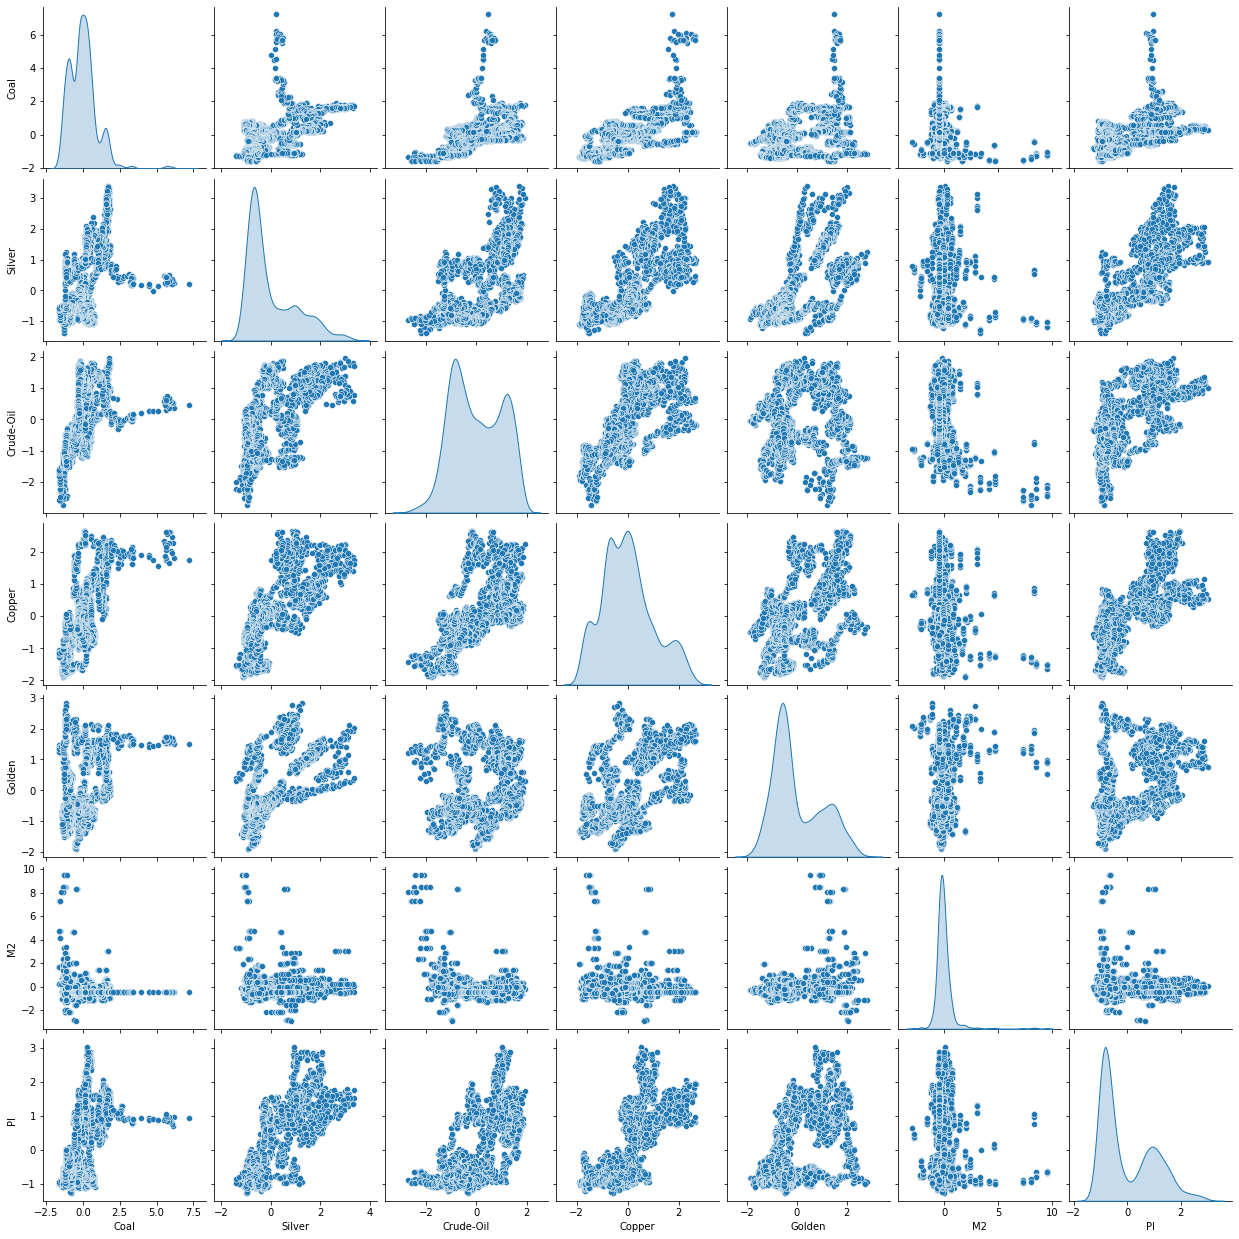

In [21]:
# Display a pairplot to look at relationships between variables
plt.figure(figsize=(10,10))
sns.pairplot(data=data_normalized,diag_kind='kde')
plt.show()

### 1.7 Time Series Features
Two time series features are added. One is the month, using to add seasonal feature. Another is the lag of PI itself, to capture some auto-correlation inside data.

In [22]:
data_normalized["month"] = data_normalized.index.month

Since the acf of PI seems to be very strong, we will choose PI in the previous 7 days as feature in our model

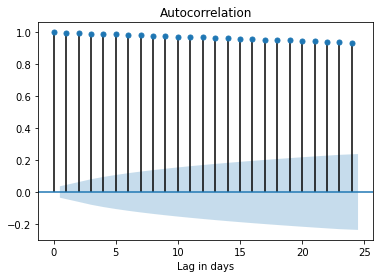

In [23]:
lag = 24
plot_acf(data_normalized["PI"], lags = lag, alpha=0.05)
plt.xlabel('Lag in days')
plt.show()

In [24]:
lag = 8
for i in range(1, lag):
  data_normalized["PI_{}".format(i)] = data_normalized["PI"].shift(i)
data_normalized

,Coal,Silver,Crude-Oil,Copper,Golden,M2,PI,month,PI_1,PI_2,PI_3,PI_4,PI_5,PI_6,PI_7
Date,,,,,,,,,,,,,,,
2009-09-01,-0.486616,-0.941665,-0.058673,-0.481303,-1.908934,-0.293171,-0.813386,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-09-02,-0.516506,-0.881440,-0.062298,-0.469133,-1.867065,-0.293171,-0.827549,9,-0.813386,NaN,NaN,NaN,NaN,NaN,NaN
2009-09-03,-0.505298,-0.750316,-0.068189,-0.405854,-1.789308,-0.293171,-0.875098,9,-0.827549,-0.813386,NaN,NaN,NaN,NaN,NaN
2009-09-04,-0.533320,-0.754128,-0.065923,-0.403420,-1.763674,-0.293171,-0.950973,9,-0.875098,-0.827549,-0.813386,NaN,NaN,NaN,NaN
2009-09-08,-0.520243,-0.698858,0.075911,-0.258202,-1.713260,-0.370480,-0.962944,9,-0.950973,-0.875098,-0.827549,-0.813386,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-26,5.706257,0.450380,0.735688,2.224295,1.639689,-0.445445,0.958189,10,0.969857,0.924163,0.873748,0.953670,0.861439,0.852503,0.827885
2021-10-27,5.663289,0.436276,0.600651,2.067719,1.681131,-0.445445,1.009211,10,0.958189,0.969857,0.924163,0.873748,0.953670,0.861439,0.852503
2021-10-28,5.668894,0.443328,0.606089,2.147224,1.716164,-0.445445,1.054871,10,1.009211,0.958189,0.969857,0.924163,0.873748,0.953670,0.861439


### 1.8 Train test set construction

We will predict the price in the next 7 days, therefore our target y will be the price in the next 7 days

In [25]:
y = pd.DataFrame()
for i in range(lag, lag + 7):
  data_normalized["y_{}".format(i - lag + 1)] = data_normalized["PI"].shift(i)
data_with_label = data_normalized.dropna(axis = 0, how = 'any')


In [26]:
labels = ["y_1", "y_2", "y_3", "y_4", "y_5", "y_6", "y_7"]
y = data_with_label[labels]
X = data_with_label.loc[:, ~data_with_label.columns.isin(labels)]

In [27]:
X.head()

,Coal,Silver,Crude-Oil,Copper,Golden,M2,PI,month,PI_1,PI_2,PI_3,PI_4,PI_5,PI_6,PI_7
Date,,,,,,,,,,,,,,,
2009-09-22,-0.458594,-0.614237,0.094943,-0.406665,-1.656865,-0.450130,-0.978625,9,-1.008133,-0.945577,-0.891284,-0.868016,-0.824008,-1.021622,-0.986382
2009-09-23,-0.464199,-0.669889,-0.030125,-0.498339,-1.672672,-0.450130,-0.961258,9,-0.978625,-1.008133,-0.945577,-0.891284,-0.868016,-0.824008,-1.021622
2009-09-24,-0.486616,-0.767850,-0.166068,-0.658160,-1.674808,-0.450130,-0.911012,9,-0.961258,-0.978625,-1.008133,-0.945577,-0.891284,-0.868016,-0.824008
2009-09-25,-0.488484,-0.785765,-0.158365,-0.607861,-1.752993,-0.450130,-0.979637,9,-0.911012,-0.961258,-0.978625,-1.008133,-0.945577,-0.891284,-0.868016
2009-09-28,-0.454858,-0.753366,-0.123019,-0.629766,-1.751711,-0.468872,-0.966148,9,-0.979637,-0.911012,-0.961258,-0.978625,-1.008133,-0.945577,-0.891284


In [28]:
y.head()

,y_1,y_2,y_3,y_4,y_5,y_6,y_7
Date,,,,,,,
2009-09-22,-0.973567,-0.985370,-0.962944,-0.950973,-0.875098,-0.827549,-0.813386
2009-09-23,-0.986382,-0.973567,-0.985370,-0.962944,-0.950973,-0.875098,-0.827549
2009-09-24,-1.021622,-0.986382,-0.973567,-0.985370,-0.962944,-0.950973,-0.875098
2009-09-25,-0.824008,-1.021622,-0.986382,-0.973567,-0.985370,-0.962944,-0.950973
2009-09-28,-0.868016,-0.824008,-1.021622,-0.986382,-0.973567,-0.985370,-0.962944


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

### 1.9 Feature Selection

We will use the day 7's price to do the feature selection. It makes sense because the prediction of day 7 is more valueable than the prediction of day 1. Univariate selection is applied.

In [30]:
# Evaluate continuous features using pearson's correlation coefficient (score_func = f_regression)
ftest = SelectKBest(score_func=f_regression, k='all')
ftest.fit(X_train,y_train["y_7"])
f_scores = pd.DataFrame(ftest.scores_)
dfcolumns = pd.DataFrame(X_train.columns)
f_scores = pd.concat([dfcolumns,f_scores],axis=1)
f_scores.columns = ['Feature','F-Score']  
f_scores = f_scores.sort_values(by='F-Score',ascending=False)
f_scores

,Feature,F-Score
14,PI_7,62300.422362
13,PI_6,54640.653089
12,PI_5,48348.377495
11,PI_4,42257.361783
10,PI_3,38559.414349
9,PI_2,34514.803469
8,PI_1,32082.788319
6,PI,30356.304607
1,Silver,3880.674915
3,Copper,2687.661580


Last two features are  dropped

In [31]:
features = f_scores['Feature'][:-2]
X_train = X_train[features]
X_test = X_test[features]
X_train

,PI_7,PI_6,PI_5,PI_4,PI_3,PI_2,PI_1,PI,Silver,Copper,Crude-Oil,Golden,Coal
Date,,,,,,,,,,,,,
2018-09-12,-0.808091,-0.823165,-0.872737,-0.895837,-0.893645,-0.833450,-0.893476,-0.936472,-1.056970,-0.712515,0.043738,-0.881004,0.718332
2014-12-18,-0.189352,-0.240273,-0.160351,-0.107744,-0.079754,-0.100325,-0.006576,0.038612,-0.809017,-0.402609,-0.689902,-0.866478,-0.372660
2014-11-10,-0.429354,-0.394654,-0.417990,-0.496732,-0.489144,-0.485266,-0.492011,-0.502633,-0.849421,-0.154359,0.363657,-1.024555,-0.307275
2019-07-02,-0.623528,-0.564345,-0.575575,-0.567987,-0.573990,-0.642008,-0.733969,-0.778146,-0.895162,-0.731986,-0.607430,-0.045757,-1.114310
2014-12-01,-0.484086,-0.406693,-0.369936,-0.396340,-0.315204,-0.284854,-0.295038,-0.191712,-0.719441,-0.315803,-0.019249,-0.887840,-0.303539
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-11-05,2.288067,2.247431,2.159247,2.175906,2.247229,2.277781,2.181504,2.133618,1.524907,0.575787,0.735688,1.203481,0.208331
2013-02-20,1.625084,1.523748,1.461867,1.477211,1.454280,1.507392,1.561517,1.614967,1.117052,0.799698,1.156205,0.797607,0.238221
2016-05-27,-0.487290,-0.545629,-0.537367,-0.584242,-0.585422,-0.506680,-0.462166,-0.441596,-0.756796,-1.624387,-0.908317,-0.792566,-1.134860


## 2. Model Fitting
We build a simple neuron network to do the regression task

### 2.0 Import Libraries

In [32]:
import torch
import torch.nn as nn

### 2.1 Construct Nerwork

In [33]:
myNet = nn.Sequential(
    nn.Linear(len(X_train.columns), 100),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Linear(50, len(y_train.columns)),
).cuda()
print(myNet)

Sequential(
  (0): Linear(in_features=13, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=50, bias=True)
  (3): ReLU()
  (4): Linear(in_features=50, out_features=7, bias=True)
)


### 2.2 Optimizer

In [34]:
optimzer = torch.optim.SGD(myNet.parameters(), lr=0.05)
loss_func = nn.MSELoss().cuda()

### 2.3 Train the network

In [35]:
X_train_tensor = torch.from_numpy(X_train.values).to(torch.float32).cuda()
y_train_tensor = torch.from_numpy(y_train.values).to(torch.float32).cuda()
losses =[]
for epoch in range(10000):
    out = myNet(X_train_tensor)
    loss = loss_func(out, y_train_tensor)
    losses.append(loss.data.cpu().numpy())
    optimzer.zero_grad()
    loss.backward()
    optimzer.step()

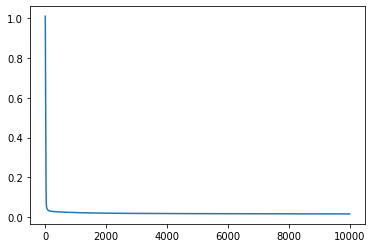

In [36]:
plt.plot(losses)
plt.show()

2.4 Result

In [37]:
print(myNet(X_train_tensor).data)

tensor([[-0.8060, -0.8143, -0.8275,  ..., -0.8174, -0.8231, -0.8080],
        [-0.2395, -0.2714, -0.2798,  ..., -0.3218, -0.3295, -0.3387],
        [-0.4524, -0.4583, -0.4599,  ..., -0.4705, -0.4681, -0.4852],
        ...,
        [-0.5204, -0.5279, -0.5295,  ..., -0.5275, -0.5344, -0.5394],
        [-0.8999, -0.8829, -0.8890,  ..., -0.9105, -0.8948, -0.8974],
        [-0.4998, -0.5276, -0.5276,  ..., -0.5451, -0.5642, -0.5673]],
       device='cuda:0')


In [38]:
y_train_tensor

tensor([[-0.9075, -0.9016, -0.9940,  ..., -0.9108, -0.8888, -0.8346],
        [-0.1661, -0.1883, -0.2632,  ..., -0.2568, -0.1917, -0.2950],
        [-0.3840, -0.4966, -0.5325,  ..., -0.5492, -0.6352, -0.6382],
        ...,
        [-0.4746, -0.5342, -0.5375,  ..., -0.5817, -0.5578, -0.7063],
        [-0.8193, -0.7771, -0.8080,  ..., -0.7412, -0.7178, -0.7001],
        [-0.5205, -0.5284, -0.5234,  ..., -0.5075, -0.5038, -0.5551]],
       device='cuda:0')

## 3. Result Presentation

In [39]:
X_test_tensor = torch.from_numpy(X_test.values).to(torch.float32).cuda()
y_predict = myNet(X_test_tensor).data.cpu().numpy()

In [40]:
y_predict = pd.DataFrame(y_predict, columns = y_test.columns, index = X_test.index).sort_index(ascending=False)
y_test = y_test.sort_index(ascending=False)

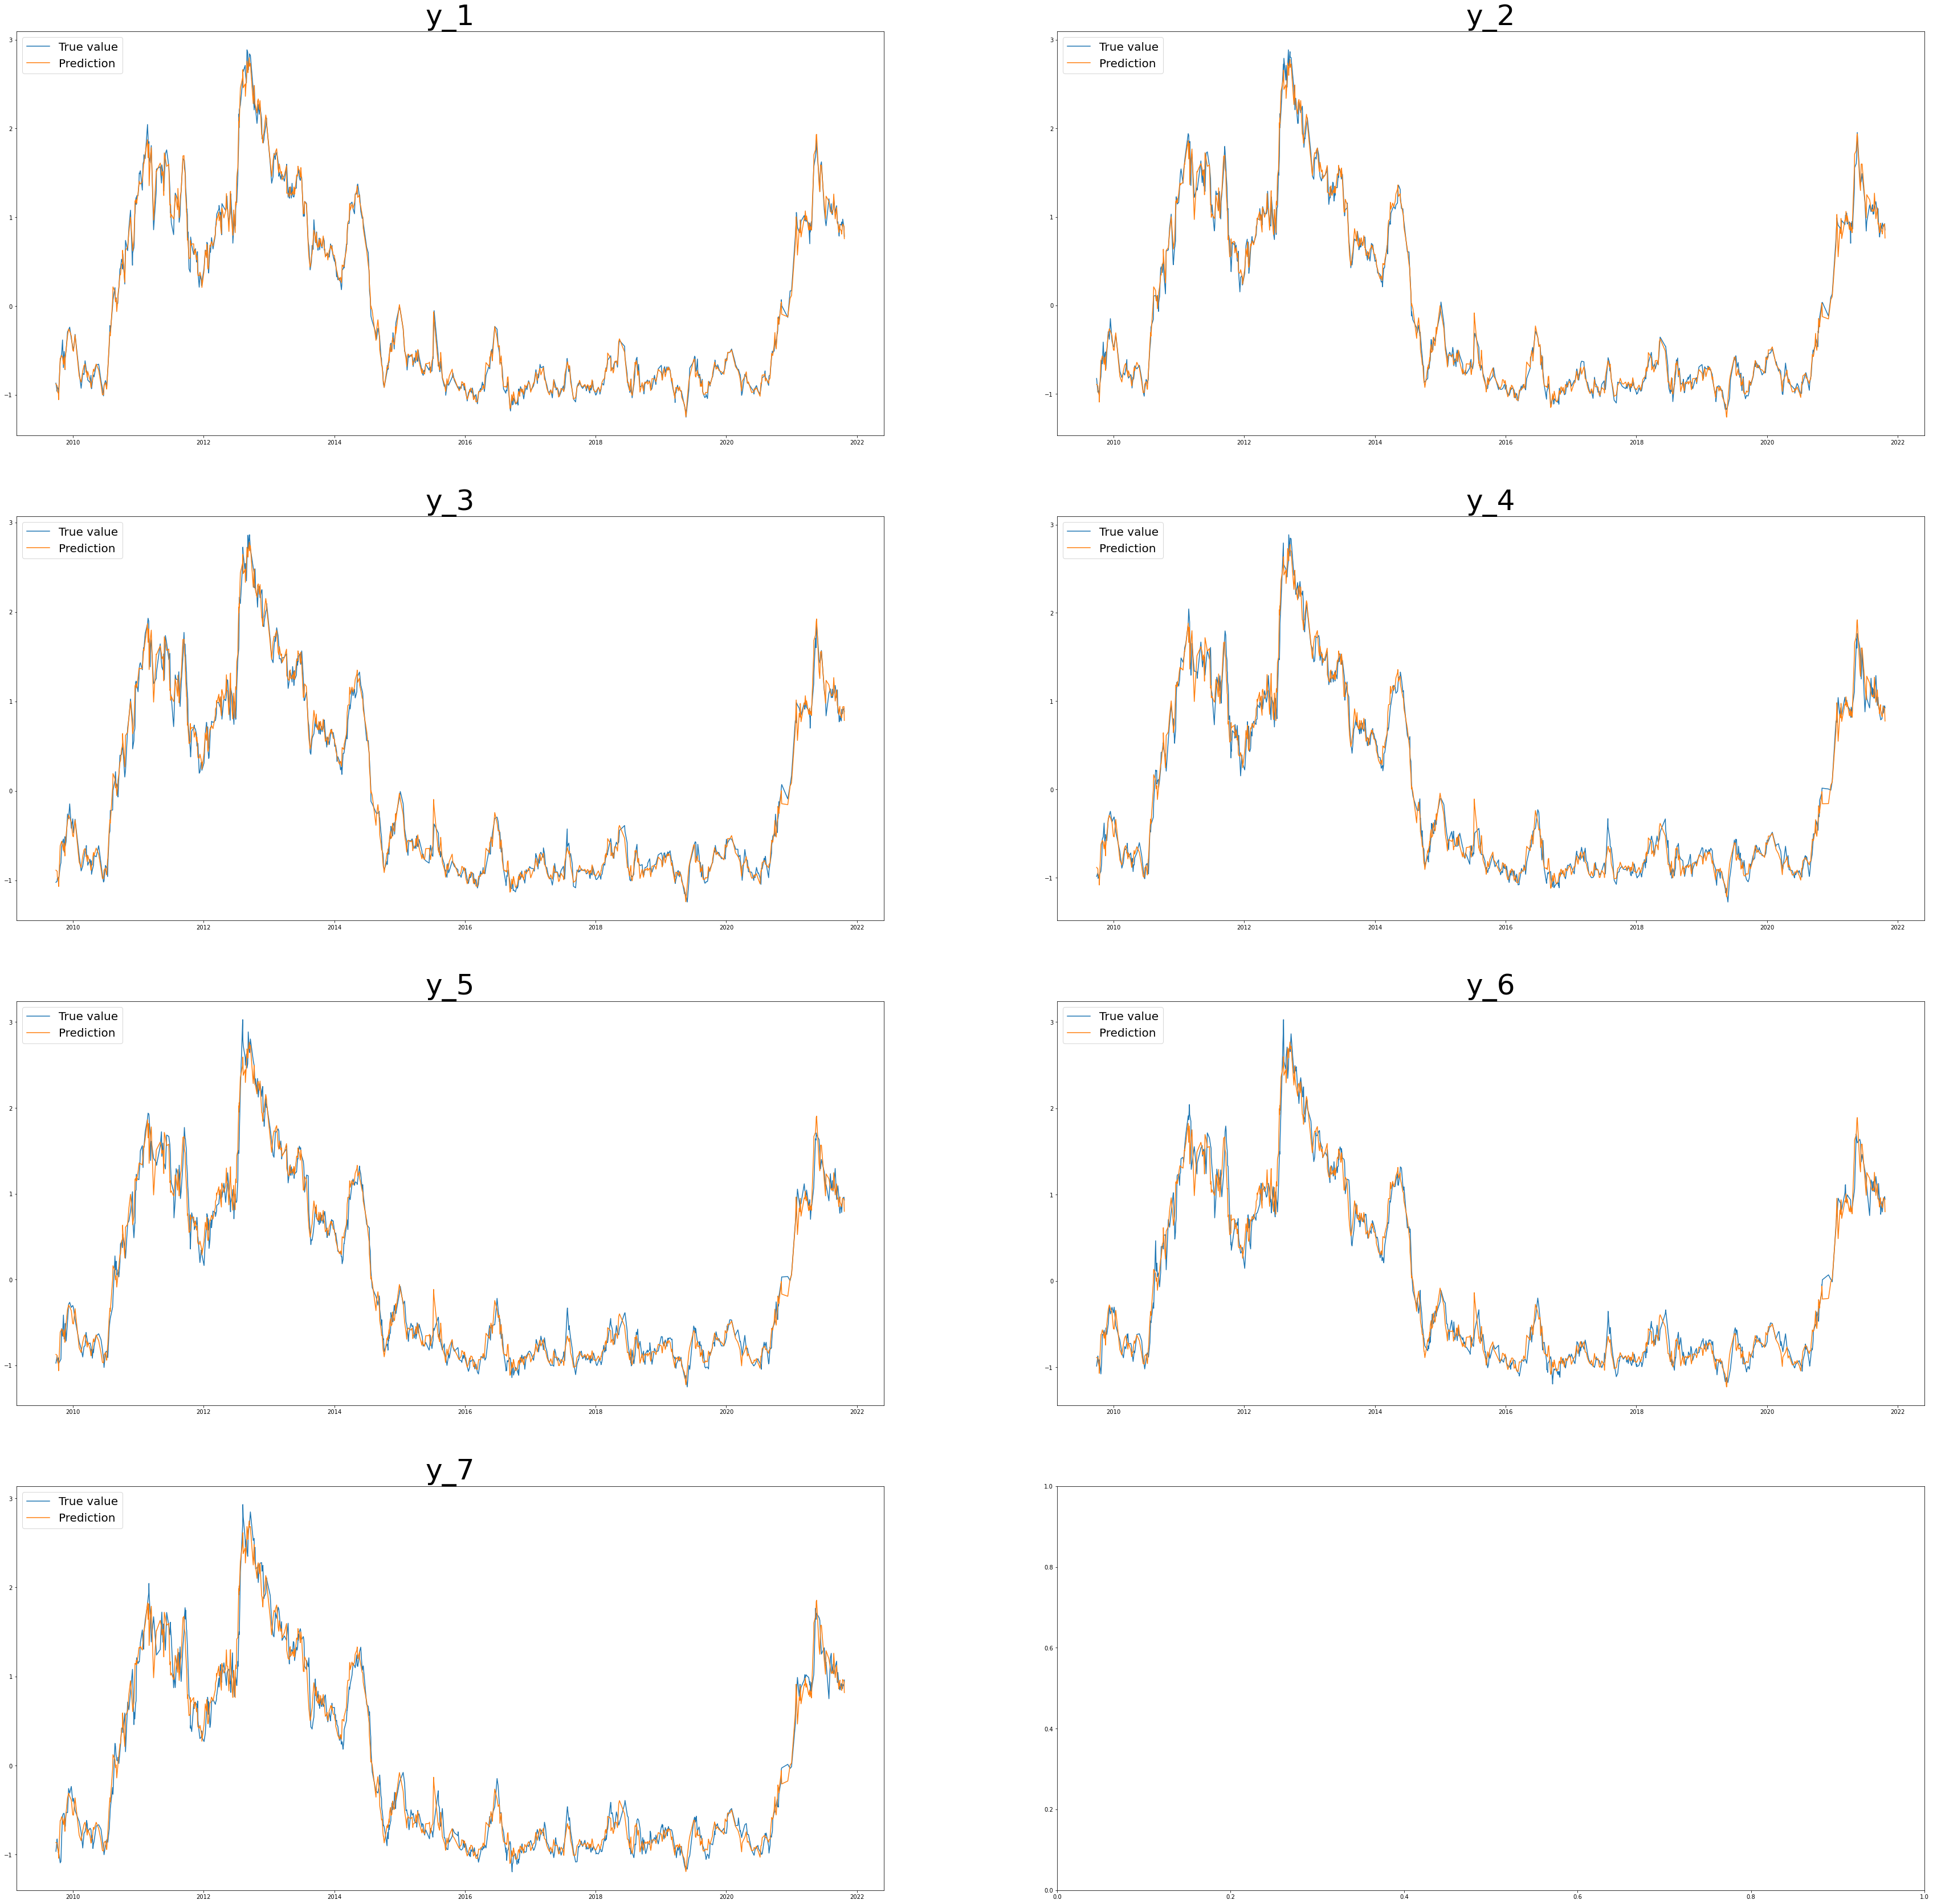

In [41]:
num = len(y_predict.columns)
fig, ax = plt.subplots(num//2+1, 2, figsize = (60, 60))

for i, sig in enumerate(y_predict.columns):
  axis = ax[i//2, i%2]
  l1, = axis.plot(y_test[sig])
  l2, = axis.plot(y_predict[sig])
  axis.set_title(sig, fontsize = 50)
  axis.legend(handles = [l1, l2], labels = ["True value", "Prediction"], loc = 'upper left', fontsize = 20)
plt.show()

In [42]:
r2 = []
for col in y_predict.columns:
  r2.append(r2_score(y_predict[col], y_test[col]))
r2

[0.9945236234102295,
 0.9904387519754012,
 0.9866149270027116,
 0.9823307118939815,
 0.9781306612793115,
 0.9742456789479929,
 0.9713657577911752]

In [43]:
mse = []
for col in y_predict.columns:
  mse.append(mean_squared_error(y_predict[col], y_test[col]))
mse

[0.005576754754616278,
 0.009735588809973928,
 0.013624415373778186,
 0.01793633653522101,
 0.022027773819997473,
 0.02575637755710292,
 0.028494889080257192]